# Lab 3 Vision par ordinateur : Apprentissage profond

Author: Mohsen Benlazreg M.ing en GPA

Mise à jour: Étienne Pepin

REF : https://keras.io/examples/
#### requirements :
numpy  
sklearn  
tensorflow

## Séance 2 : Utilisation des architectures pré-entraînées

Une approche courante et très efficace de l'apprentissage profond consiste à conserver une partie d'un réseau de neurones pré-entrainé. Un réseau pré-entrainé est simplement un réseau entrainé sur une grande base données, généralement sur une tâche de classification d'images à grande échelle.

Si cette base de données utilisée est assez grande et assez générale, alors la hiérarchie des caractéristiques spatiales apprise par le réseau pré-entrainé peut effectivement agir comme un modèle générique de notre monde visuel, et donc ses caractéristiques peuvent s'avérer utiles pour de nombreux problèmes de vision par ordinateur différents, même si ces nouveaux problèmes puissent impliquer des classes complètement différentes.

Dans notre cas, nous considérerons un grand convnet entrainé sur la base de données ImageNet (1,4 million d'images étiquetées et 1000 classes différentes).

Nous utiliserons l'architecture VGG16, développée par Karen Simonyan et Andrew Zisserman en 2014, une architecture convnet simple et largement utilisée.

C'est un modèle un peu plus ancien, loin de l'état de l'art actuel mais nous l'avons choisi car son architecture est facile à comprendre sans introduire de nouveaux concepts.

Le modèle VGG16 est donné dans le framework Keras. Vous pouvez l'importer depuis le module `keras.applications`. Voici la liste quelques modèles pré-entrainé sur ImageNet fournit par Keras:
* Xception
* InceptionV3
* ResNet50
* VGG16
* VGG19
* MobileNet

Il existe deux façons d'exploiter un réseau pré-entrainé :
- Utiliser ce réseau comme un extracteur de caractéristiques.
- Adapter une partie de ce réseau par un petit entrainement. 

![image.png](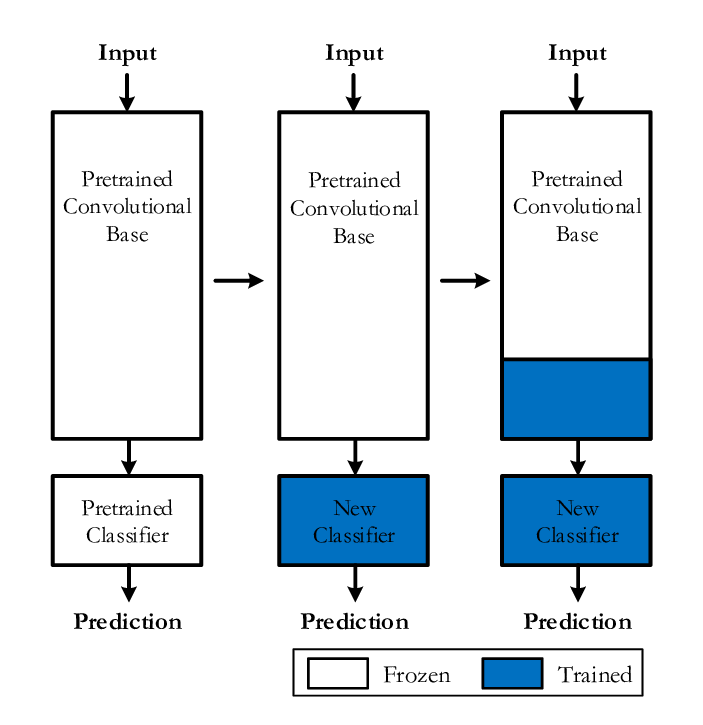
)

[source](https://www.researchgate.net/figure/TOP-LEVEL-DIAGRAM-OF-TRANSFER-LEARNING-FROM-A-PRE-TRAINED-CNN-MODEL_fig4_333882146)
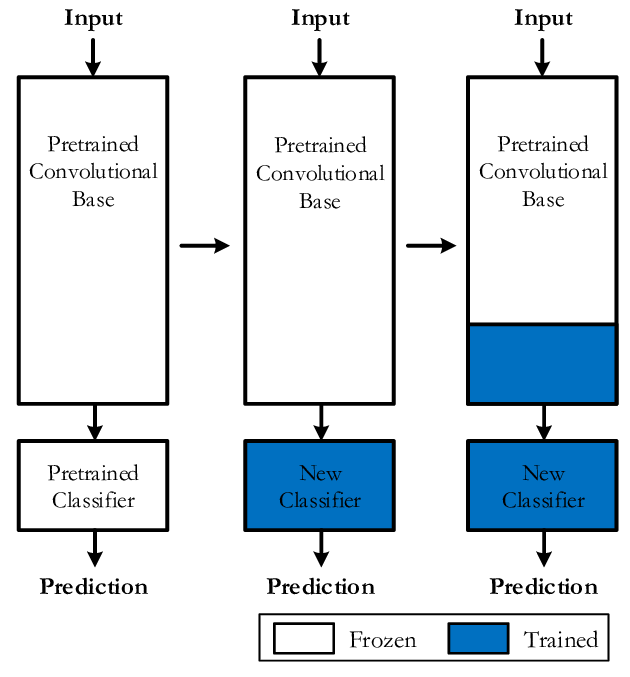

## Partie 1 : Extraction de caractéristiques 

Cette technique consiste à utiliser la partie d'extraction de caractéristiques " `conv_base` " du CNN. 


In [1]:
import tensorflow as tf
import os
#os.environ["CUDA_VISIBLE_DEVICES"]="-1"  #disables GPU 
import matplotlib.pyplot as plt
import numpy as np
tf.__version__

'2.8.0'

In [2]:
from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 5922693064349549980
xla_global_id: -1
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 4162256896
locality {
  bus_id: 1
  links {
  }
}
incarnation: 3964583563398428110
physical_device_desc: "device: 0, name: NVIDIA GeForce RTX 2060, pci bus id: 0000:2b:00.0, compute capability: 7.5"
xla_global_id: 416903419
]


In [36]:
from tensorflow.keras.applications import VGG16

conv_base = VGG16(weights='imagenet',
                  include_top=False,
                  input_shape=(224, 224, 3))

In [15]:
conv_base.trainable = False # l'entrainement va pas affecter cette partie
conv_base.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

La dernière couche est une couche de pooling de forme (4,4,512), c'est à partir de cette couche qu'on va coller un un perceptron multicouche pour la classification.

### Exercice 1 :

#### 1- Ajouter une couche de flatten et un perceptron multicouche (à vous de choisir les hyper-paramétres : nombre de couches, nombre de neurones dans chaque couche, fonction d'activation).

(indice: 
model = models.Sequential()

model.add(conv_base)

model.add(layers.Flatten())
)

In [39]:
from tensorflow.keras import layers
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten
from tensorflow.keras.optimizers import RMSprop

from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical


top_model = conv_base.output   #https://www.learndatasci.com/tutorials/hands-on-transfer-learning-keras/
top_model  = Flatten()(top_model)
top_model = Dense(100)(top_model)
top_model = Activation('relu')(top_model)
top_model = Dense(50)(top_model)
top_model = Dropout(0.3)(top_model)
top_model = Dense(10)(top_model)
output =  Activation('softmax')(top_model)

model = Model(inputs = conv_base.input, outputs = output)
model.summary()


Model: "model_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_5 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0   

#### 2 - Faire le preprocessing des données mini-caltech101 pour que vos images soient preprocess de la même façon qu'elles l'étaient lors de l'entraînement de VGG16

voir https://www.tensorflow.org/api_docs/python/tf/keras/applications/vgg16/preprocess_input, prêter attention à l'input range des images de cette fonction.

In [6]:
from tensorflow.keras.applications.vgg16 import preprocess_input
from tensorflow.keras.preprocessing import image

import os
import cv2
import numpy as np
#https://machinelearningmastery.com/use-pre-trained-vgg-model-classify-objects-photographs/
   
def load_data (data_path,img_shape):
    data_dir_list = os.listdir(data_path)
    img_rows=img_shape[0]
    img_cols=img_shape[1]
    num_channel=img_shape[2]

    labels=[]
    data=[]
    len_list_img=0
    num_class=0
    for dataset in data_dir_list:
        img_list=os.listdir(data_path+'/'+ dataset)    
        for img in img_list:
            input_img=image.load_img(data_path + '/'+ dataset + '/'+ img , target_size=(img_rows, img_cols))    
            input_img =  image.img_to_array(input_img)
            data.append(input_img)
            labels.append(num_class)
        num_class+=1

    data = np.array(data)
    data = data.astype('float32')
    #data /= 255
    labels=np.array(labels)
    print('data shape',data.shape)
    print('labels shape',labels.shape)
    return data, labels

In [40]:
data_path='mini_Caltech101'
img_shape=[224,224,3]
data, labels=load_data(data_path,img_shape)

num_classes=10
n_epoch=20
lr = 1e-5

Y = to_categorical(labels, num_classes)
X_train,y_train = shuffle(data,Y, random_state=2)

X_train, X_test, y_train , y_test = train_test_split(X_train,y_train, test_size=0.3, random_state=2)

X_train = preprocess_input(X_train.copy()) 
X_test = preprocess_input(X_test.copy())

data shape (500, 224, 224, 3)
labels shape (500,)


#### 3- Faire l'entrainement sur  avec un lr=1e-5 pendant 20 époques.

In [41]:
optimizer = RMSprop(learning_rate = lr)
model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=["accuracy"])
hist = model.fit(X_train, y_train, batch_size=15, epochs=20, verbose=1, validation_data=(X_test, y_test))

Epoch 1/20
24/24 [==============================] - 3s 112ms/step - loss: 13.6911 - accuracy: 0.2543 - val_loss: 4.4663 - val_accuracy: 0.5800
Epoch 2/20
24/24 [==============================] - 2s 105ms/step - loss: 3.3441 - accuracy: 0.6114 - val_loss: 2.9535 - val_accuracy: 0.6667
Epoch 3/20
24/24 [==============================] - 3s 107ms/step - loss: 1.1952 - accuracy: 0.7857 - val_loss: 2.2774 - val_accuracy: 0.7067
Epoch 4/20
24/24 [==============================] - 3s 106ms/step - loss: 0.6860 - accuracy: 0.9029 - val_loss: 1.9183 - val_accuracy: 0.7667
Epoch 5/20
24/24 [==============================] - 2s 105ms/step - loss: 0.4087 - accuracy: 0.9143 - val_loss: 1.6394 - val_accuracy: 0.8000
Epoch 6/20
24/24 [==============================] - 3s 106ms/step - loss: 0.3150 - accuracy: 0.9429 - val_loss: 1.4623 - val_accuracy: 0.8200
Epoch 7/20
24/24 [==============================] - 3s 106ms/step - loss: 0.1427 - accuracy: 0.9714 - val_loss: 1.3810 - val_accuracy: 0.8333
Epoch

#### 4- Tracer les courbes de précision et d'erreur et comparer les résultats obtenus avec les résultats du lab précedent. 



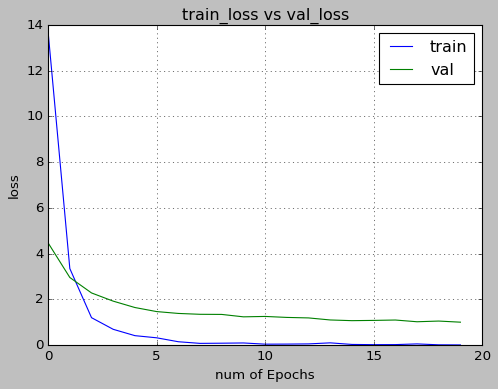

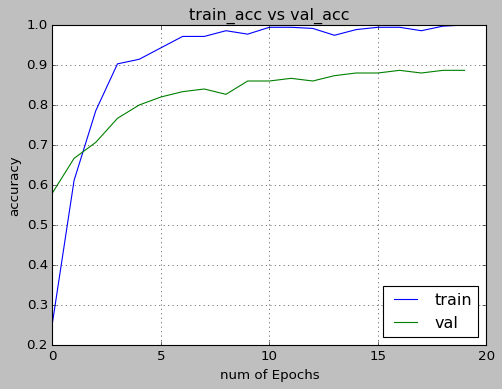

In [42]:
# visualizing losses and accuracy
train_loss=hist.history['loss']
val_loss=hist.history['val_loss']
train_acc=hist.history['accuracy']
val_acc=hist.history['val_accuracy']
xc=range(n_epoch)

plt.figure(1,figsize=(7,5))
plt.plot(xc,train_loss)
plt.plot(xc,val_loss)
plt.xlabel('num of Epochs')
plt.ylabel('loss')
plt.title('train_loss vs val_loss')
plt.grid(True)
plt.legend(['train','val'])
plt.style.use(['classic'])

plt.figure(2,figsize=(7,5))
plt.plot(xc,train_acc)
plt.plot(xc,val_acc)
plt.xlabel('num of Epochs')
plt.ylabel('accuracy')
plt.title('train_acc vs val_acc')
plt.grid(True)
plt.legend(['train','val'],loc=4)
plt.style.use(['classic'])

Nous voyons dans les graphique ci-dessus, une ameleioration significative avec le nouveau model. Le modele de la premiere section avait une performace (validation croisée) de 72%, tandis que ce modele a une performance de 87%. De plus, Au lab précedant, on a obtenu une performance de 72% après 100 époches. Avec VGG16, on dépace 72% après 3 époches. 

## Partie 2 : Adaptation d'un CNN pré-entraîné   

Dans cette partie, on va faire un petit réglage pour quelques couches de convolution de notre modèle. Cette méthode ajuste légèrement les représentations les plus abstraites du modèle réutilisé, afin de les rendre plus pertinentes pour le problème en question.


In [43]:
conv_base.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_5 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     


Les étapes suivantes résument cet algorithme :

1- Ajouter un perceptron multicouche.

2- Débloquer quelques couches de la base de convolution. 

3- Faire l'entrainement. 

Par exemple, on va débloquer les couches qui suivent `block4_pool` et laisser les autres bloquées. C'est à dire, les couches `block5_conv1`, `block5_conv2` et `block5_conv3` vont être modifiées lors de l'entrainement.

In [44]:
conv_base.trainable = True

set_trainable = False
for layer in conv_base.layers:
    if layer.name == 'block5_conv1':
        set_trainable = True
    if set_trainable:
        layer.trainable = True
    else:
        layer.trainable = False

### Exercice 2:  

#### 1- Réaliser l'entrainement du CNN pré-entrainé adapté sur mini-caltech101 (lr=1e-5, 20 époques). 

In [45]:
#https://keras.io/guides/transfer_learning/

'''top_model = conv_base.output   #https://www.learndatasci.com/tutorials/hands-on-transfer-learning-keras/
top_model  = Flatten()(top_model)
top_model = Dense(100)(top_model)
top_model = Activation('relu')(top_model)
top_model = Dense(50)(top_model)
top_model = Dropout(0.3)(top_model)
top_model = Dense(10)(top_model)
output =  Activation('softmax')(top_model)

model = Model(inputs = conv_base.input, outputs = output)'''

model.compile(loss='categorical_crossentropy', optimizer = RMSprop(learning_rate = 1e-5) , metrics=["accuracy"])
hist = model.fit(X_train, y_train, batch_size=15, epochs=20, verbose=1, validation_data=(X_test, y_test))

Epoch 1/20
24/24 [==============================] - 3s 111ms/step - loss: 0.0350 - accuracy: 0.9971 - val_loss: 0.9169 - val_accuracy: 0.9000
Epoch 2/20
24/24 [==============================] - 2s 103ms/step - loss: 0.0105 - accuracy: 0.9914 - val_loss: 0.8968 - val_accuracy: 0.9000
Epoch 3/20
24/24 [==============================] - 2s 103ms/step - loss: 0.0148 - accuracy: 0.9943 - val_loss: 0.8079 - val_accuracy: 0.9067
Epoch 4/20
24/24 [==============================] - 2s 103ms/step - loss: 4.1725e-04 - accuracy: 1.0000 - val_loss: 0.7871 - val_accuracy: 0.9133
Epoch 5/20
24/24 [==============================] - 2s 104ms/step - loss: 0.0155 - accuracy: 0.9914 - val_loss: 0.7722 - val_accuracy: 0.9067
Epoch 6/20
24/24 [==============================] - 2s 104ms/step - loss: 0.0058 - accuracy: 0.9971 - val_loss: 0.8224 - val_accuracy: 0.9067
Epoch 7/20
24/24 [==============================] - 2s 104ms/step - loss: 0.0029 - accuracy: 0.9971 - val_loss: 0.8005 - val_accuracy: 0.9000
Ep

#### 2- Comparer les résultats obtenus avec les résultats de l'exercice 1. 


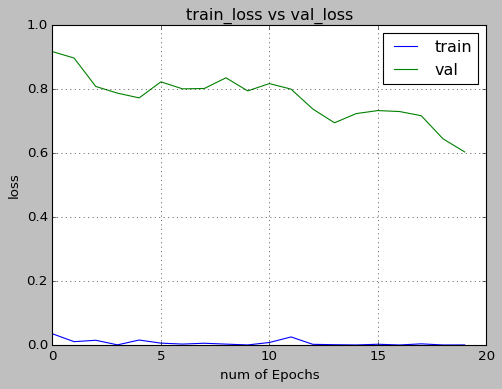

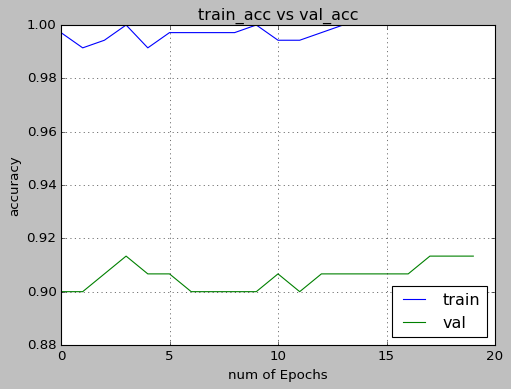

In [46]:
# visualizing losses and accuracy
train_loss=hist.history['loss']
val_loss=hist.history['val_loss']
train_acc=hist.history['accuracy']
val_acc=hist.history['val_accuracy']
xc=range(n_epoch)

plt.figure(1,figsize=(7,5))
plt.plot(xc,train_loss)
plt.plot(xc,val_loss)
plt.xlabel('num of Epochs')
plt.ylabel('loss')
plt.title('train_loss vs val_loss')
plt.grid(True)
plt.legend(['train','val'])
plt.style.use(['classic'])

plt.figure(2,figsize=(7,5))
plt.plot(xc,train_acc)
plt.plot(xc,val_acc)
plt.xlabel('num of Epochs')
plt.ylabel('accuracy')
plt.title('train_acc vs val_acc')
plt.grid(True)
plt.legend(['train','val'],loc=4)
plt.style.use(['classic'])

A cette étape, nous avons continué l'entrainement du CNN de la section 1, mais nous avons aussi entrainé quelques couches du VGG16. 
A la fin de la première section, on a observé que la performance convergeait vers 87%. A cette étape nous avons atteint une performance de 91%. On pourrait probablement obtenir une meilleur performance si on ajoute plus de neurones au couches denses.

#### 3- Expliquer pourquoi on utilise un lr (learning rate) faible.


Dans cette section, on introduit une nouvelle base de données à un CNN qui à déja était entraîné. Nous voulons donc pas trop modifier ses poids. 

D'après la [documentation de Keras](https://keras.io/api/optimizers/sgd/), les nouveaux poids calculés sont définis par `w = w - learning_rate * gradient`. Donc, si le lr est trop grand, les poids subirons des variations indésirables.   

De plus, souvent lors de l'entrainement d'un RN, on va décroitre le lr. Puisque le VGG16 est déja entrainé, nous vollons choisir un lr qui est déja diminué. [source](https://www.tensorflow.org/api_docs/python/tf/keras/optimizers/schedules/LearningRateSchedule)

## Partie 3 : KNN + CNN pré-entrainé

### Exercice 3 : 

#### 1- Ajouter le VGG entrainé sur ImageNet. (indice : include_top = True)

- Pour la bases de données mini-caltech101 :

In [1]:
import gc
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.vgg16 import decode_predictions

gc.collect()

model = VGG16(weights='imagenet',
                  include_top=True,
                  input_shape=(224, 224, 3))


NameError: name 'VGG16' is not defined

#### 2- Extraire le vecteur de caractéristique de l'avant dernière couche. (vecteur de 4096 valeurs)

(indice : 
get_layer_output= K.function([model.input], [model.layers[layer_idx].output])

avec le `num_layer` et le numéro de la couche en considération)

In [154]:
from tensorflow.keras import backend as K

get_layer_output = K.function([model.input], [model.layers[-2].output])


#### 3- Utiliser KNN pour classifier les images (K=1). 

(indice : from sklearn.neighbors import KNeighborsClassifier)

In [151]:
data_path='mini_Caltech101'
img_shape=[224,224,3]
data, labels=load_data(data_path,img_shape)

X_train,y_train = shuffle(data, labels, random_state=2)

X_train, X_test, y_train , y_test = train_test_split(X_train,y_train, test_size=0.3, random_state=2)

X_train = preprocess_input(X_train.copy()) 
X_test = preprocess_input(X_test.copy())

data shape (500, 224, 224, 3)
labels shape (500,)


In [152]:
import time

training = []
training_label = []

from sklearn.neighbors import KNeighborsClassifier

start_time = time.time()

neigh = KNeighborsClassifier(n_neighbors=1)
for i, x in enumerate(X_train):
    x = x.reshape(1,224,224,3)
    layer_output = np.array(get_layer_output(x))
    layer_output = layer_output[0,0,:]
    training.append(layer_output) 
    training_label.append(y_train[i])

neigh.fit(training, training_label)
print("--- %s seconds ---" % (time.time() - start_time))


--- 4.023634672164917 seconds ---


#### 4- Comparer les résultats obtenues avec les résultats de l'exercice 1 et 2. 

In [148]:
testing = []
testing_label = []

for i, x in enumerate(X_test):
    x = x.reshape(1,224,224,3)
    layer_output = np.array(get_layer_output(x))
    layer_output = layer_output[0,0,:]

    testing.append(layer_output)
    testing_label.append(y_test[i])

neigh.score(testing, testing_label)


0.9533333333333334

Voici la performance de chaque sections:

- Section 1: 88%
- Section 2: 91%
- Section 3: 95%

Nous étions surpris aussi du temps d'entrainement requis par le KNN pour obtenir une aussi bonne performance. Voici le temps d'entrainement de chaque sections:

- Section 1: 50 secondes
- Section 2: 51 secondes
- Section 3: 4  secondes

## Évaluation : 

Exercice 1 : 30%
    
Exercice 2 : 30%
    
Exercice 3 : 40%